Import data from 311 complaint and only focus on beach BIA area
https://open.toronto.ca/dataset/polls-conducted-by-the-city/

In [4]:
pip install tabulate
from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
df = pd.read_csv("SR2024.csv", on_bad_lines="skip")
target_zips = ["M4E", "M4L", "M4M"]
df = df[df["First 3 Chars of Postal Code"].isin(target_zips)]
print(df["First 3 Chars of Postal Code"].unique())

['M4E' 'M4L' 'M4M']


In [2]:
section_counts = df["Status"].value_counts()
print(section_counts)

Status
Completed      14228
Cancelled       2265
In Progress      587
Closed           341
New              234
Unknown          158
Name: count, dtype: int64


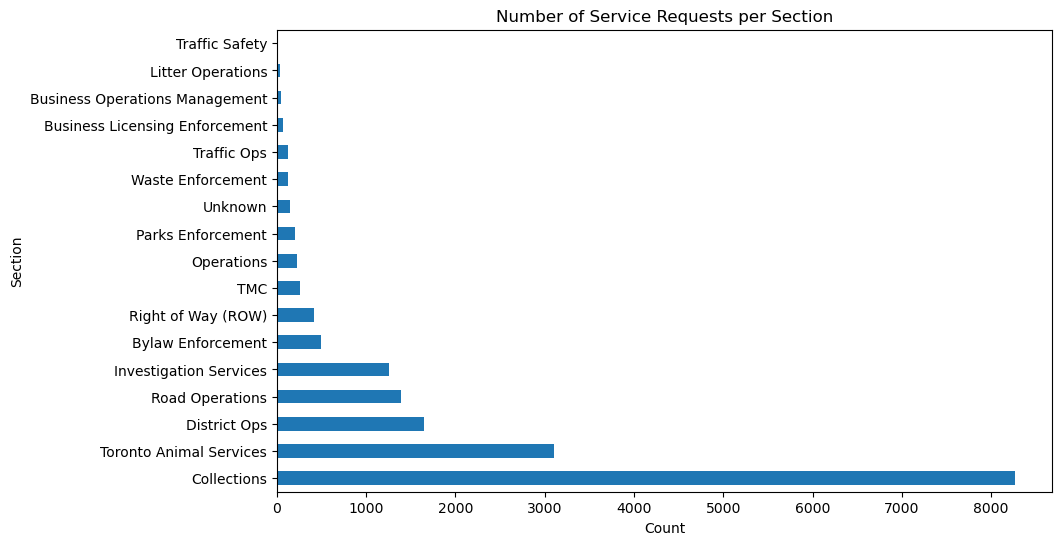

In [3]:
section_counts = df["Section"].value_counts()

plt.figure(figsize=(10,6))
section_counts.plot(kind="barh")

plt.title("Number of Service Requests per Section")
plt.xlabel("Count")
plt.ylabel("Section")
plt.show()

In [5]:
def plot_section_requests(df, section_name, min_pct=0):
    """
    Plot the distribution of Service Request Types for a given section.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least 'Section' and
        'Service Request Type' columns.
    section_name : str
        Name of the section to analyze (e.g., 'Collections').
    min_pct : float, optional
        Minimum percentage threshold for displaying a request type.
        Default is 0 (percentage points).
    """
    # Check whether the section exists
    if section_name not in df["Section"].unique():
        print(f"Section '{section_name}' does not exist. Available sections:")
        print(df["Section"].unique())
        return

    # Subset data for the selected section
    subset = df[df["Section"] == section_name]

    counts = subset["Service Request Type"].value_counts()
    percentages = counts / counts.sum() * 100

    # Apply percentage threshold
    mask = percentages >= min_pct
    counts = counts[mask]
    percentages = percentages[mask]

    if counts.empty:
        print(f"No service request type exceeds {min_pct}%")
        return

    # Create plot
    plt.figure(figsize=(10, 6))
    counts.plot(kind="barh")
    plt.title(
        f"Service Request Types in Section: {section_name}",
        fontsize=14
    )
    plt.xlabel("Count", fontsize=12)
    plt.ylabel("Service Request Type", fontsize=12)

    # Annotate percentages on bars
    for i, (count, pct) in enumerate(zip(counts, percentages)):
        plt.text(
            count + max(counts) * 0.01,
            i,
            f"{pct:.1f}%",
            va="center",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()

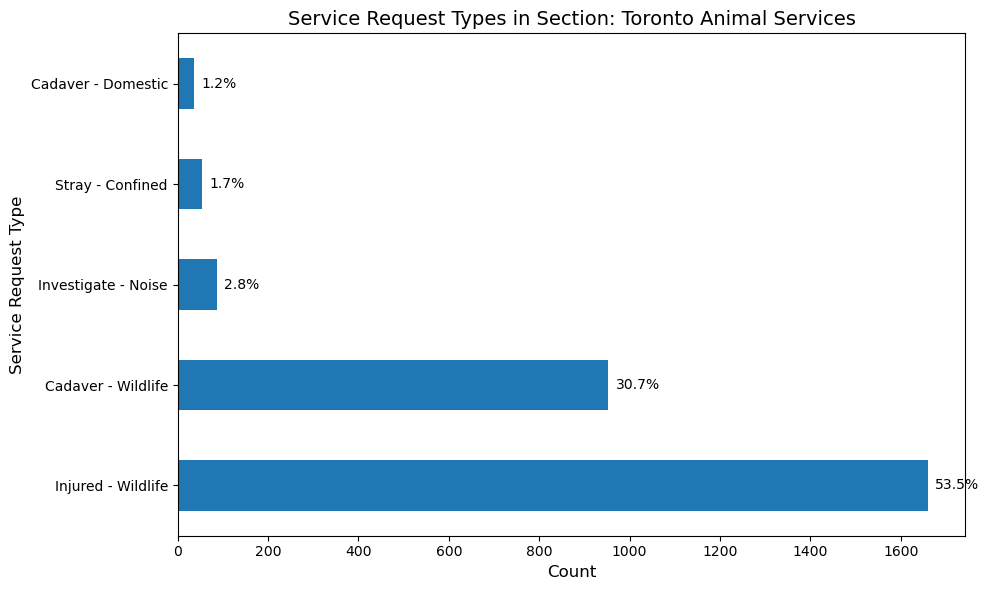

In [6]:
plot_section_requests(df, "Toronto Animal Services", min_pct=1)

In [7]:
def find_top_requests(df, sections, min_count=50, latex=True):
    """
    Find Service Request Types with counts >= min_count within specified sections,
    and optionally print the results as a LaTeX table.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least 'Section' and 'Service Request Type' columns.
    sections : list[str]
        List of section names to filter on.
    min_count : int, optional
        Minimum count threshold. Default is 50.
    latex : bool, optional
        If True, print a LaTeX table. If False, print a Markdown table.
        Default is True.

    Returns
    -------
    pandas.DataFrame | None
        A DataFrame of results sorted by Section and Count (descending),
        or None if no rows meet the criteria.
    """
    results = []

    for section in sections:
        subset = df[df["Section"] == section]
        counts = subset["Service Request Type"].value_counts()
        filtered = counts[counts >= min_count]

        if filtered.empty:
            continue

        temp = pd.DataFrame(
            {
                "Section": section,
                "Service Request Type": filtered.index,
                "Count": filtered.values,
            }
        )
        results.append(temp)

    if not results:
        print("No records meet the criteria.")
        return None

    final_df = pd.concat(results, ignore_index=True)
    final_df = final_df.sort_values(
        ["Section", "Count"],
        ascending=[True, False]
    )

    tablefmt = "latex_booktabs" if latex else "github"
    label = "LaTeX" if latex else "Markdown"

    print(f"\n{label} table output:\n")
    print(
        tabulate(
            final_df,
            headers="keys",
            tablefmt=tablefmt,
            floatfmt=".0f",
            showindex=False,
        )
    )

    return final_df

In [8]:
sections_to_check = [
    "Toronto Animal Services",
    "Parks Enforcement",
]

find_top_requests(
    df,
    sections_to_check,
    min_count=50,
    latex=True,
)


LaTeX table output:

\begin{tabular}{llr}
\toprule
 Section                 & Service Request Type   &   Count \\
\midrule
 Parks Enforcement       & Dogs off Leash         &      99 \\
 Parks Enforcement       & Park Use               &      74 \\
 Toronto Animal Services & Injured - Wildlife     &    1660 \\
 Toronto Animal Services & Cadaver - Wildlife     &     953 \\
 Toronto Animal Services & Investigate - Noise    &      87 \\
 Toronto Animal Services & Stray - Confined       &      53 \\
\bottomrule
\end{tabular}


Section Service Request Type  Count
4        Parks Enforcement       Dogs off Leash     99
5        Parks Enforcement             Park Use     74
0  Toronto Animal Services   Injured - Wildlife   1660
1  Toronto Animal Services   Cadaver - Wildlife    953
2  Toronto Animal Services  Investigate - Noise     87
3  Toronto Animal Services     Stray - Confined     53

In [9]:
section_counts = df["Section"].value_counts()

mask = df["Section"] == "Collections"

df.loc[mask, "Service Request Type"] = (
    df.loc[mask, "Service Request Type"]
        .str.split(r"[/,:|&]| and ")
        .apply(
            lambda parts: (
                parts[-1].strip()
                if isinstance(parts, list) and len(parts) > 0
                else np.nan
            )
        )
)

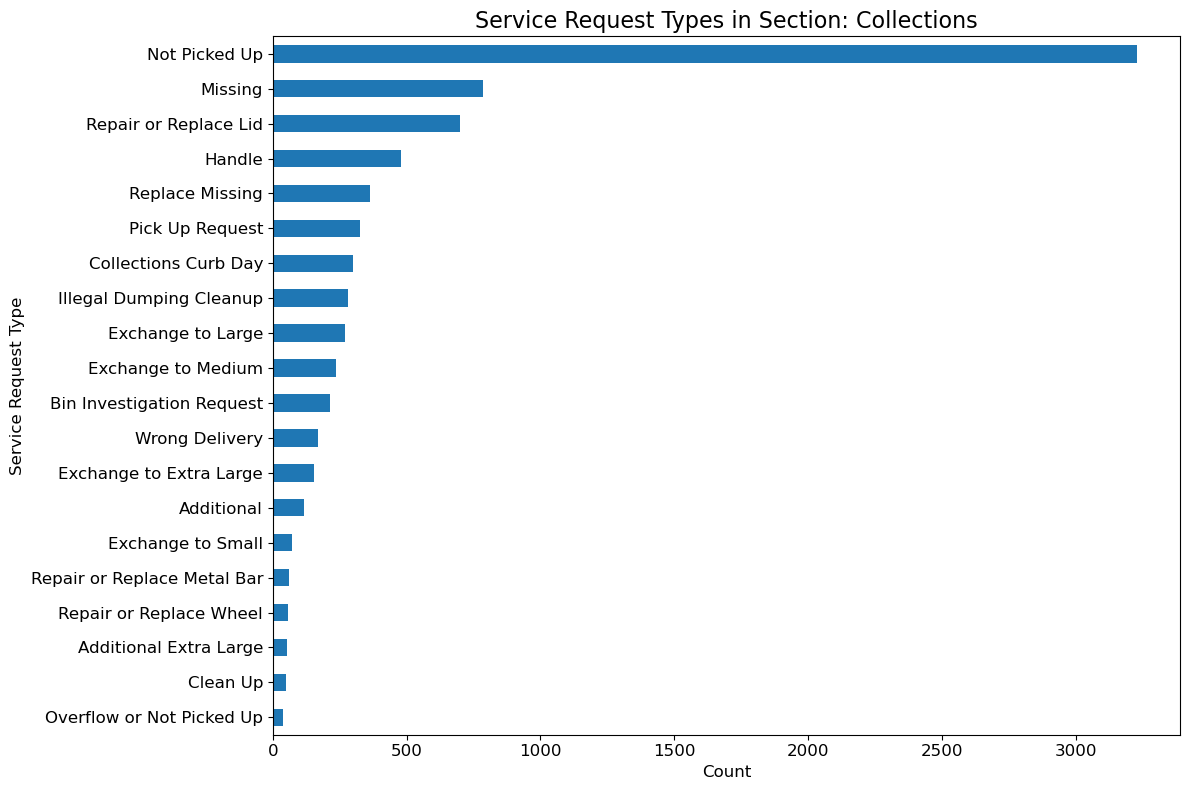

In [10]:
def plot_section_barplot(df, section="Collections", top_n=None, fontsize=12):
    """
    Plot the distribution of Service Request Types within a section.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'Section' and 'Service Request Type' columns.
    section : str, optional
        Section name to filter on. Default is "Collections".
    top_n : int or None, optional
        If provided, display only the top N request types by count.
        Default is None.
    fontsize : int, optional
        Base font size for plot text. Default is 12.
    """
    counts = (
        df.loc[df["Section"] == section, "Service Request Type"]
        .value_counts()
    )

    if top_n is not None:
        counts = counts.head(top_n)

    plt.figure(figsize=(12, 8))
    counts.plot(kind="barh")

    plt.title(
        f"Service Request Types in Section: {section}",
        fontsize=fontsize + 4,
    )
    plt.xlabel("Count", fontsize=fontsize)
    plt.ylabel("Service Request Type", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()


plot_section_barplot(
    df,
    section="Collections",
    top_n=20,
    fontsize=12,
)

Collection section is quite messy, so recompile the complaints to categorize better. And try different methods to present in different part when presantation.

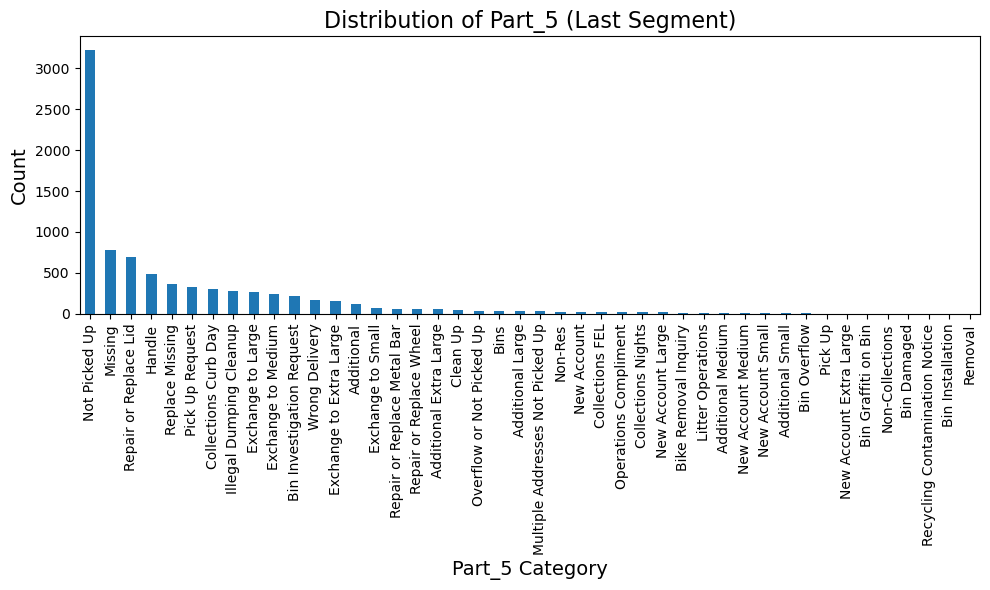

In [13]:
# Select records belonging to the Collections section
collections_df = df.loc[df["Section"] == "Collections"].copy()


# Split Service Request Type using multiple delimiters and clean whitespace
collections_df["SplitParts"] = (
    collections_df["Service Request Type"]
        .str.split(r"[/,:|&]| and ")
        .apply(
            lambda parts: (
                [part.strip() for part in parts if part.strip()]
                if isinstance(parts, list)
                else []
            )
        )
)


# Right-align list elements so the last segment appears in the last column
def right_align(parts, max_parts=5):
    parts = parts[-max_parts:]
    return [np.nan] * (max_parts - len(parts)) + parts


# Apply right alignment and expand into multiple columns
aligned_parts = collections_df["SplitParts"].apply(
    lambda parts: pd.Series(
        right_align(parts, max_parts=5)
    )
)

aligned_parts.columns = [
    f"Part_{i + 1}"
    for i in range(aligned_parts.shape[1])
]


# Merge expanded parts back into the original DataFrame
collections_with_parts = pd.concat(
    [collections_df, aligned_parts],
    axis=1,
)


collections_with_parts.head(10)


# Identify all Part_* columns
part_cols = [
    col
    for col in collections_with_parts.columns
    if col.startswith("Part_")
]


# Analyze the distribution of the last segment (Part_5)
part5 = collections_with_parts["Part_5"].dropna()

part5_counts = part5.value_counts()

plt.figure(figsize=(10, 6))
part5_counts.plot(kind="bar")

plt.title("Distribution of Part_5 (Last Segment)", fontsize=16)
plt.xlabel("Part_5 Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

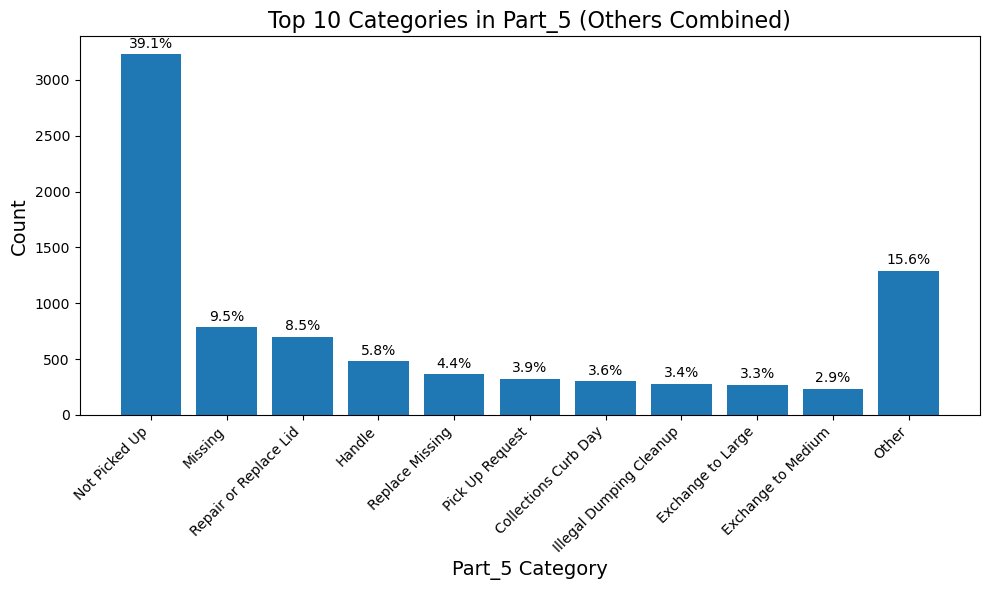

In [14]:
# Focus on the Part_5 column only
part5 = collections_with_parts["Part_5"].dropna()

# Count occurrences of each category
part5_counts = part5.value_counts()

# Select top 10 categories and combine the rest as "Other"
top10 = part5_counts.head(10)
other_sum = part5_counts.iloc[10:].sum()

part5_top10 = pd.concat(
    [
        top10,
        pd.Series({"Other": other_sum}),
    ]
)

# Compute percentages
part5_percent = part5_top10 / part5_top10.sum() * 100


# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    part5_top10.index,
    part5_top10.values,
)

# Add percentage labels above bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(part5_top10.values) * 0.01,
        f"{part5_percent.iloc[i]:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.title(
    "Top 10 Categories in Part_5 (Others Combined)",
    fontsize=16,
)
plt.xlabel("Part_5 Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

Making time series analysis.

10    2024-01-01 01:46:30
68    2024-01-01 08:49:52
70    2024-01-01 08:57:38
138   2024-01-01 11:40:35
208   2024-01-01 14:43:27
Name: Creation Date, dtype: datetime64[ns]
datetime64[ns]


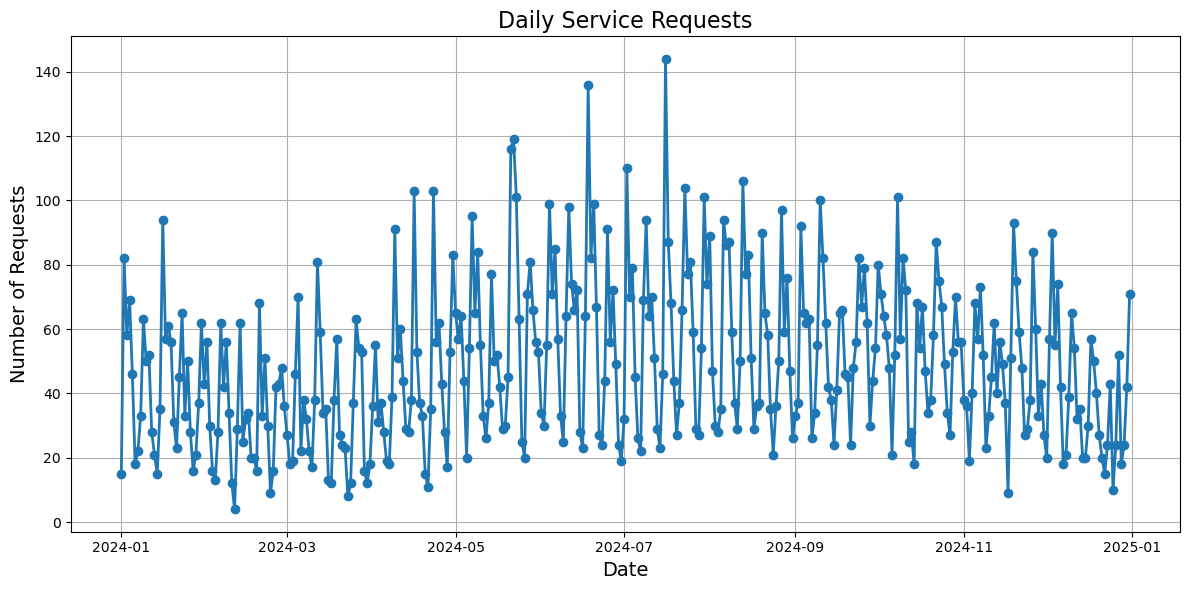

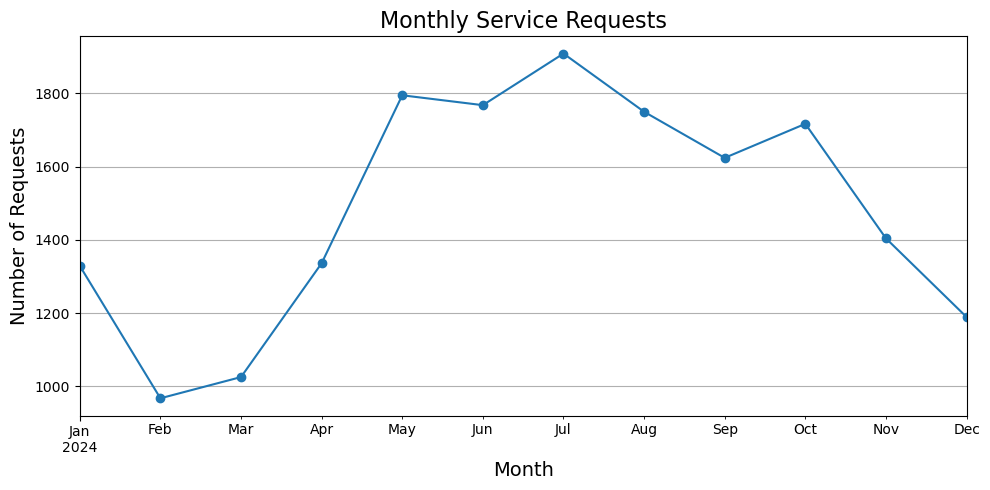

In [28]:
# Convert Creation Date to pandas datetime
df["Creation Date"] = pd.to_datetime(
    df["Creation Date"],
    errors="coerce",
)

df["Month"] = df["Creation Date"].dt.month

# Inspect conversion results
print(df["Creation Date"].head())
print(df["Creation Date"].dtype)


# Extract date (year-month-day) and month period
df["Date"] = df["Creation Date"].dt.date
df["Month"] = df["Creation Date"].dt.to_period("M")


# Compute daily request counts
daily_counts = df.groupby("Date").size()

plt.figure(figsize=(12, 6))
daily_counts.plot(
    kind="line",
    marker="o",
    linewidth=2,
)

plt.title("Daily Service Requests", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Number of Requests", fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()


# Compute monthly request counts
monthly_counts = df.groupby("Month").size()

plt.figure(figsize=(10, 5))
monthly_counts.plot(
    kind="line",
    marker="o",
)

plt.title("Monthly Service Requests", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Requests", fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()

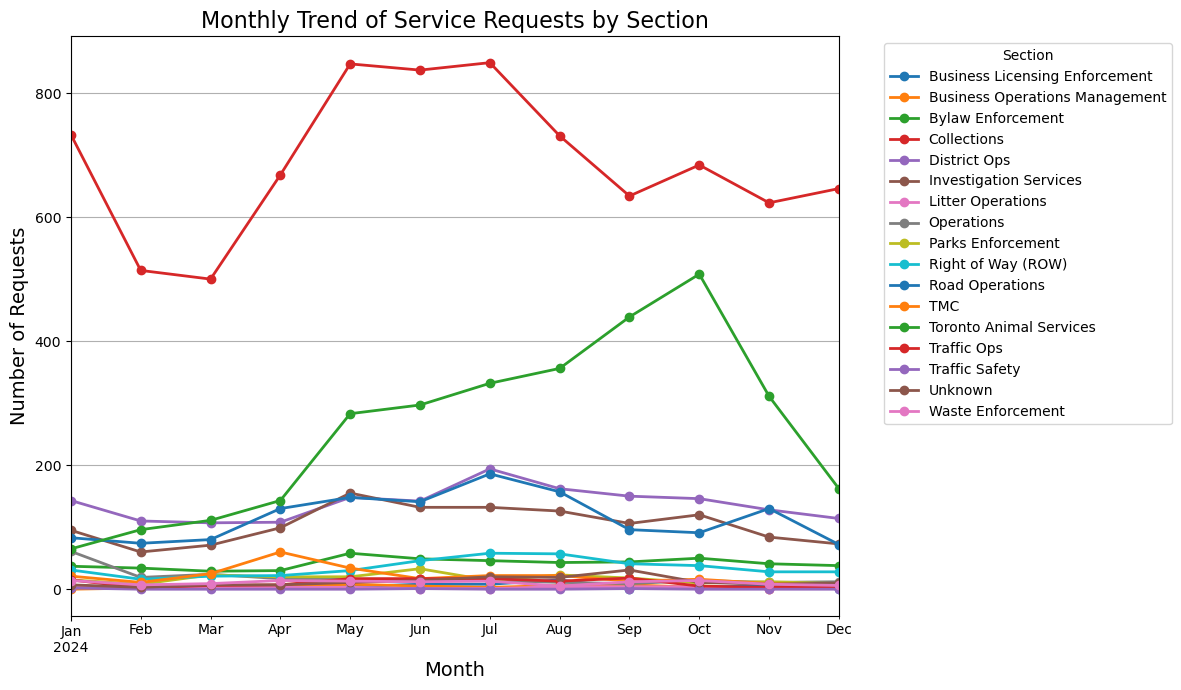

In [18]:
# Ensure Creation Date is in datetime format
df["Creation Date"] = pd.to_datetime(
    df["Creation Date"],
    errors="coerce",
)

# Extract month as a Period for monthly aggregation
df["Month"] = df["Creation Date"].dt.to_period("M")

# Count requests by Month and Section
monthly_section_counts = (
    df
    .groupby(["Month", "Section"])
    .size()
    .reset_index(name="Count")
)

# Pivot so each Section becomes its own time series
section_trend = (
    monthly_section_counts
    .pivot(
        index="Month",
        columns="Section",
        values="Count",
    )
    .fillna(0)
)

# Plot monthly trend lines
ax = section_trend.plot(
    kind="line",
    marker="o",
    linewidth=2,
    figsize=(12, 7),
)

ax.set_title(
    "Monthly Trend of Service Requests by Section",
    fontsize=16,
)
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Number of Requests", fontsize=14)
ax.legend(
    title="Section",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)
ax.grid(True)

plt.tight_layout()
plt.show()


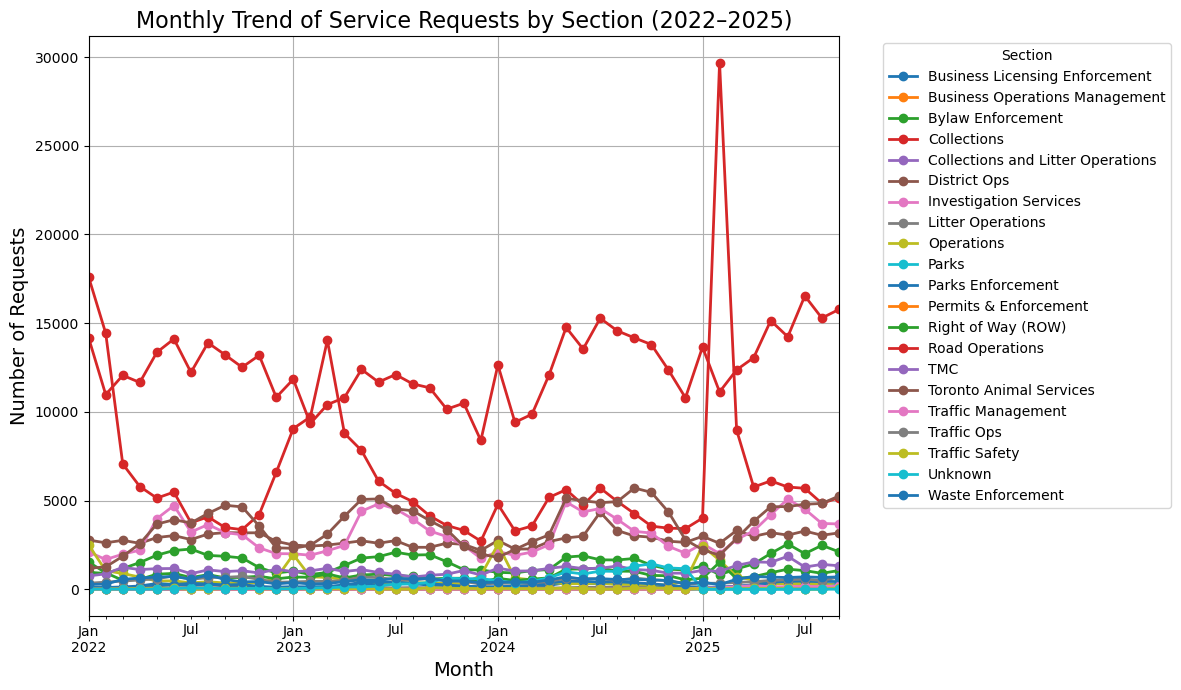

In [21]:
def safe_read_csv(path):
    """
    Read a CSV file using common encodings, falling back on decode failures.

    Parameters
    ----------
    path : str
        Path to the CSV file.

    Returns
    -------
    pandas.DataFrame
        Loaded DataFrame.

    Raises
    ------
    ValueError
        If the file cannot be decoded using the candidate encodings.
    """
    encodings = [
        "utf-8",
        "utf-8-sig",
        "latin1",
        "windows-1252",
        "ISO-8859-1",
    ]

    for encoding in encodings:
        try:
            return pd.read_csv(
                path,
                on_bad_lines="skip",
                encoding=encoding,
                low_memory=False,
            )
        except UnicodeDecodeError:
            continue

    raise ValueError(
        f"Could not decode {path} using the candidate encodings."
    )


# Read and combine multiple yearly files
files = [
    "SR2022.csv",
    "SR2023.csv",
    "SR2024.csv",
    "SR2025.csv",
]

dfs = [
    safe_read_csv(path)
    for path in files
]

df_all = pd.concat(
    dfs,
    ignore_index=True,
)

df_all.columns = df_all.columns.str.strip()


# Parse dates and construct monthly period
df_all["Creation Date"] = pd.to_datetime(
    df_all["Creation Date"],
    errors="coerce",
)

df_all = df_all.dropna(
    subset=["Creation Date", "Section"]
)

df_all["Month"] = df_all["Creation Date"].dt.to_period("M")


# Count requests by Month and Section
monthly_section_counts = (
    df_all
    .groupby(["Month", "Section"])
    .size()
    .reset_index(name="Count")
)

section_trend = (
    monthly_section_counts
    .pivot(
        index="Month",
        columns="Section",
        values="Count",
    )
    .fillna(0)
)

section_trend.index = section_trend.index.to_timestamp()


# Plot monthly trends
ax = section_trend.plot(
    kind="line",
    marker="o",
    linewidth=2,
    figsize=(12, 7),
)

ax.set_title(
    "Monthly Trend of Service Requests by Section (2022–2025)",
    fontsize=16,
)
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Number of Requests", fontsize=14)
ax.legend(
    title="Section",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)
ax.grid(True)

plt.tight_layout()
plt.show()

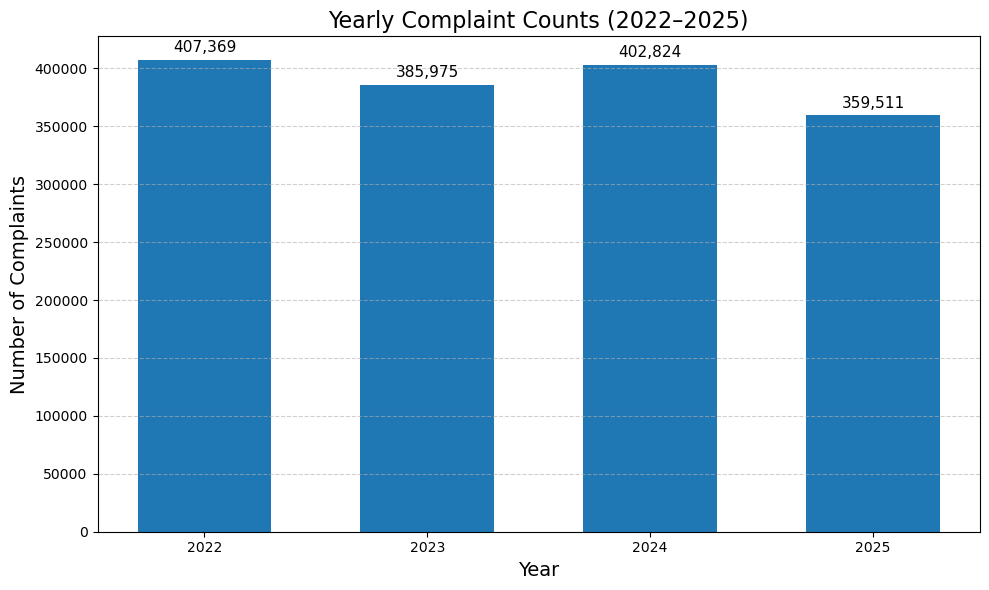

In [22]:
# Ensure Creation Date is in datetime format and extract year
df_all["Creation Date"] = pd.to_datetime(
    df_all["Creation Date"],
    errors="coerce",
)

df_all["Year"] = df_all["Creation Date"].dt.year


# Compute yearly complaint counts
yearly_counts = (
    df_all
    .groupby("Year")
    .size()
    .reset_index(name="Count")
)


# Plot yearly counts as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(
    yearly_counts["Year"],
    yearly_counts["Count"],
    width=0.6,
)

# Add value labels above bars
max_count = yearly_counts["Count"].max()

for year, count in zip(
    yearly_counts["Year"],
    yearly_counts["Count"],
):
    plt.text(
        year,
        count + max_count * 0.01,
        f"{count:,}",
        ha="center",
        va="bottom",
        fontsize=11,
    )

plt.title(
    "Yearly Complaint Counts (2022–2025)",
    fontsize=16,
)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Complaints", fontsize=14)
plt.xticks(yearly_counts["Year"])
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


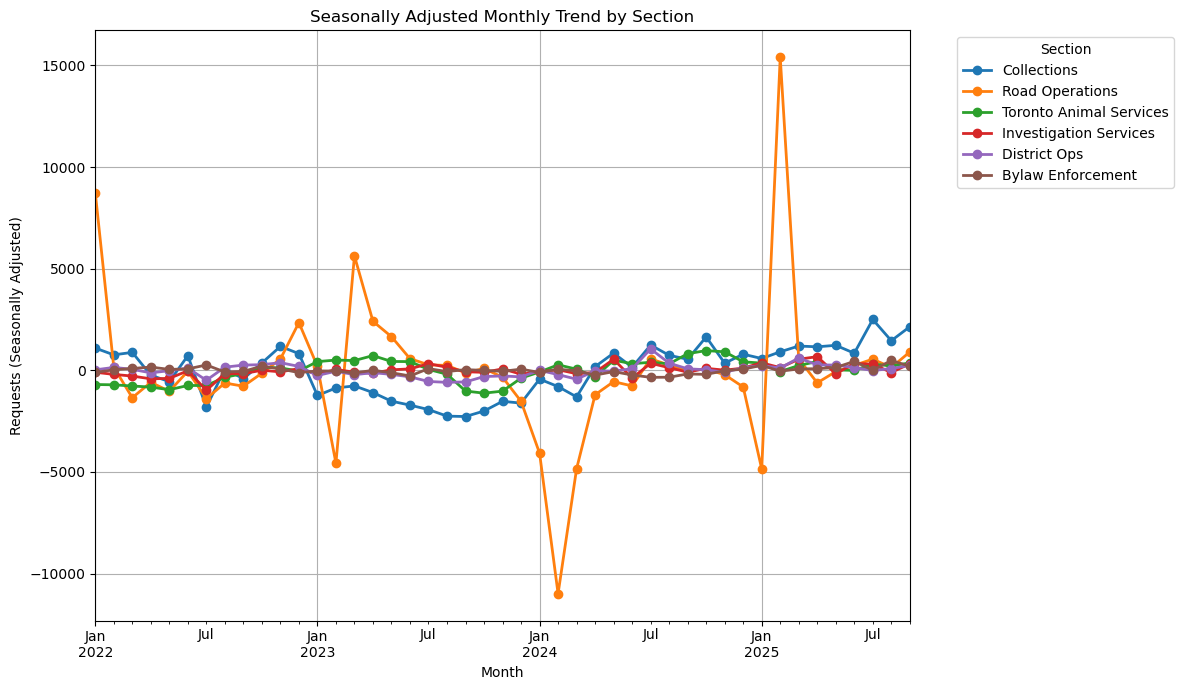

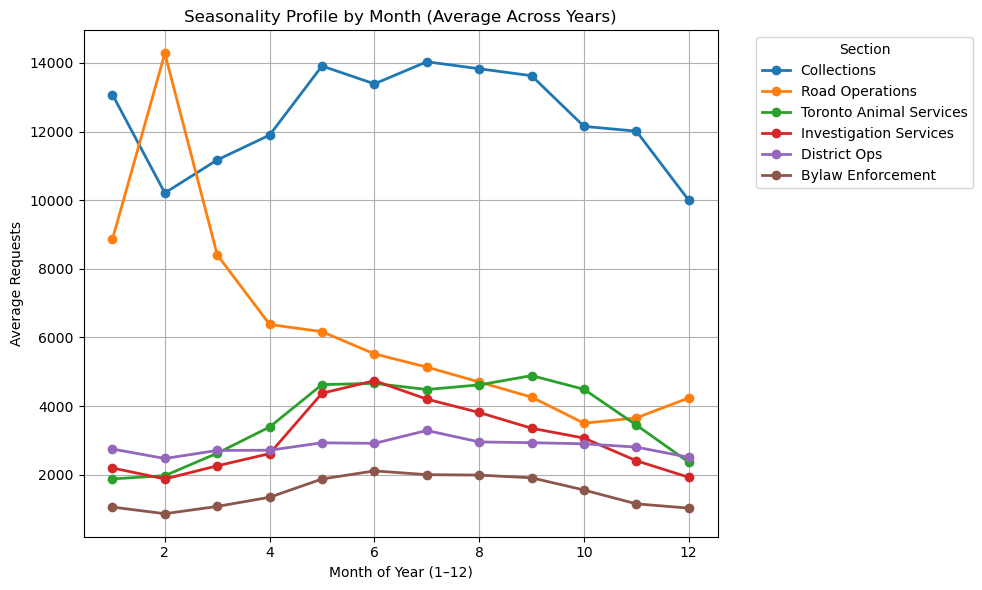

In [23]:
# Regularize to monthly start frequency and fill missing months
section_trend = section_trend.asfreq("MS").fillna(0)

# Compute monthly seasonal means across years (rows = 1..12, cols = Section)
seasonal_monthly = section_trend.groupby(section_trend.index.month).mean()
seasonal_monthly.index.name = "MonthNum"

# Align the seasonal component to the full time index
month_index = section_trend.index.month
seasonal_component = seasonal_monthly.loc[month_index].set_index(
    section_trend.index
)

# Compute seasonally adjusted series
section_trend_sa = section_trend - seasonal_component

# Plot the top 6 most active sections to reduce clutter
top_sections = (
    section_trend
    .sum()
    .sort_values(ascending=False)
    .head(6)
    .index
)

ax = section_trend_sa[top_sections].plot(
    kind="line",
    marker="o",
    linewidth=2,
    figsize=(12, 7),
)

ax.set_title("Seasonally Adjusted Monthly Trend by Section")
ax.set_xlabel("Month")
ax.set_ylabel("Requests (Seasonally Adjusted)")
ax.legend(
    title="Section",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)
ax.grid(True)

plt.tight_layout()
plt.show()


# Plot seasonality profiles (average month-of-year pattern) for the top sections
ax = seasonal_monthly[top_sections].plot(
    kind="line",
    marker="o",
    linewidth=2,
    figsize=(10, 6),
)

ax.set_title("Seasonality Profile by Month (Average Across Years)")
ax.set_xlabel("Month of Year (1–12)")
ax.set_ylabel("Average Requests")
ax.legend(
    title="Section",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)
ax.grid(True)

plt.tight_layout()
plt.show()


2022-2025(Oct)

In [29]:
def plot_overall_trend(df, freq="daily"):
    """
    Plot the overall time trend of service requests, aggregated daily or monthly.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing a 'Creation Date' column.
    freq : str, optional
        Aggregation frequency: 'daily' or 'monthly'. Default is 'daily'.

    Raises
    ------
    ValueError
        If freq is not 'daily' or 'monthly'.
    """
    df = df.copy()

    # Ensure Creation Date is in datetime format
    df["Creation Date"] = pd.to_datetime(
        df["Creation Date"],
        errors="coerce",
    )

    if freq == "daily":
        df["Date"] = df["Creation Date"].dt.date
        counts = (
            df
            .groupby("Date")
            .size()
            .sort_index()
        )
        rolling_window = 7
        title = "Daily Service Requests (Overall Trend)"
        ylabel = "Number of Daily Requests"

    elif freq == "monthly":
        df["Month"] = df["Creation Date"].dt.to_period("M")
        counts = (
            df
            .groupby("Month")
            .size()
            .sort_index()
        )
        rolling_window = 3
        title = "Monthly Service Requests (Overall Trend)"
        ylabel = "Number of Monthly Requests"

    else:
        raise ValueError(
            "freq must be either 'daily' or 'monthly'."
        )

    rolling_avg = counts.rolling(window=rolling_window).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(
        counts.index.astype(str),
        counts.values,
        label=f"{freq.capitalize()} count",
    )
    plt.plot(
        counts.index.astype(str),
        rolling_avg.values,
        label=f"{rolling_window}-period rolling average",
    )

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


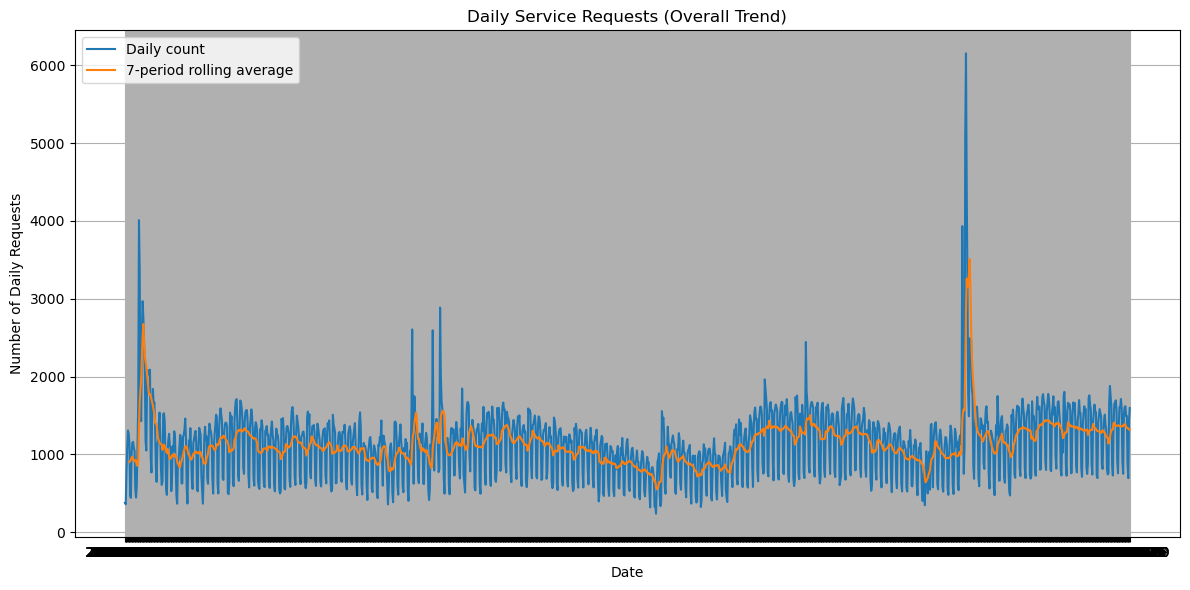

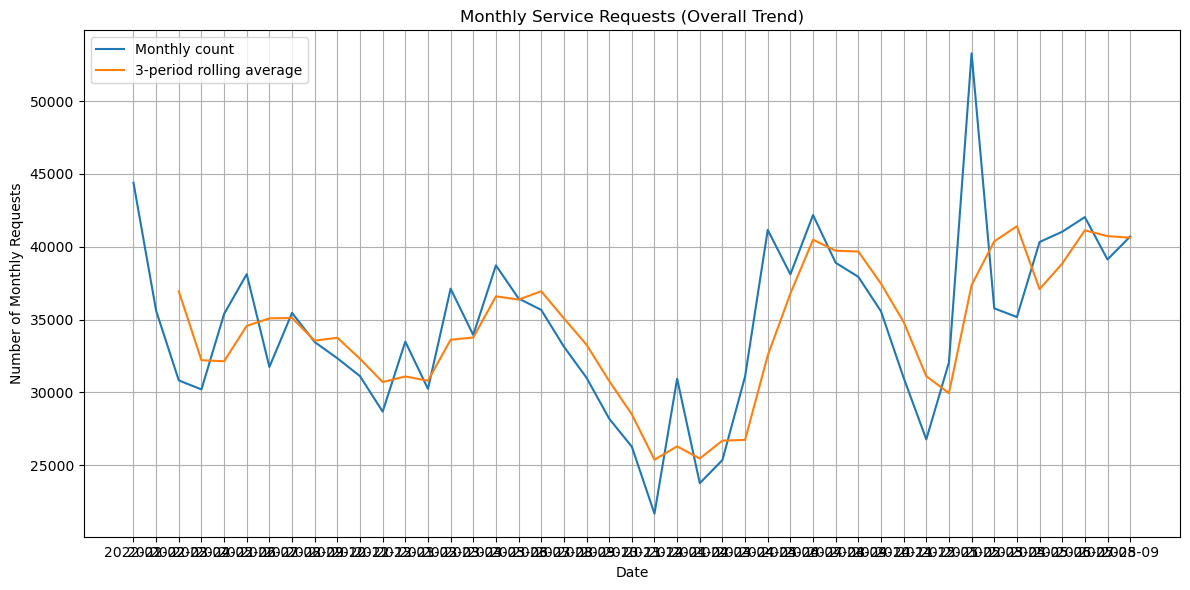

In [30]:
plot_overall_trend(df_all, freq="daily")

plot_overall_trend(df_all, freq="monthly")

In [31]:
def plot_monthly_trend_by_section(df, sections=None, smooth=True):
    """
    Plot monthly service request trends for selected sections.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'Creation Date' and 'Section' columns.
    sections : list[str] or None, optional
        List of section names to plot. If None, plot the top 5 sections
        by total volume. Default is None.
    smooth : bool, optional
        If True, apply a 3-month rolling average. Default is True.
    """
    df = df.copy()

    df["Creation Date"] = pd.to_datetime(
        df["Creation Date"],
        errors="coerce",
    )
    df["Month"] = df["Creation Date"].dt.to_period("M")

    if sections is None:
        sections = (
            df["Section"]
            .value_counts()
            .head(5)
            .index
            .tolist()
        )

    monthly_counts = (
        df.loc[df["Section"].isin(sections)]
        .groupby(["Section", "Month"])
        .size()
        .reset_index(name="Count")
    )

    plt.figure(figsize=(12, 6))

    for section in sections:
        section_data = (
            monthly_counts.loc[monthly_counts["Section"] == section]
            .sort_values("Month")
        )

        counts = section_data.set_index("Month")["Count"]

        if smooth:
            counts = counts.rolling(window=3).mean()

        plt.plot(
            counts.index.astype(str),
            counts.values,
            label=section,
        )

    plt.title("Monthly Service Requests by Section")
    plt.xlabel("Month")
    plt.ylabel("Number of Requests")
    plt.legend(title="Section")
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


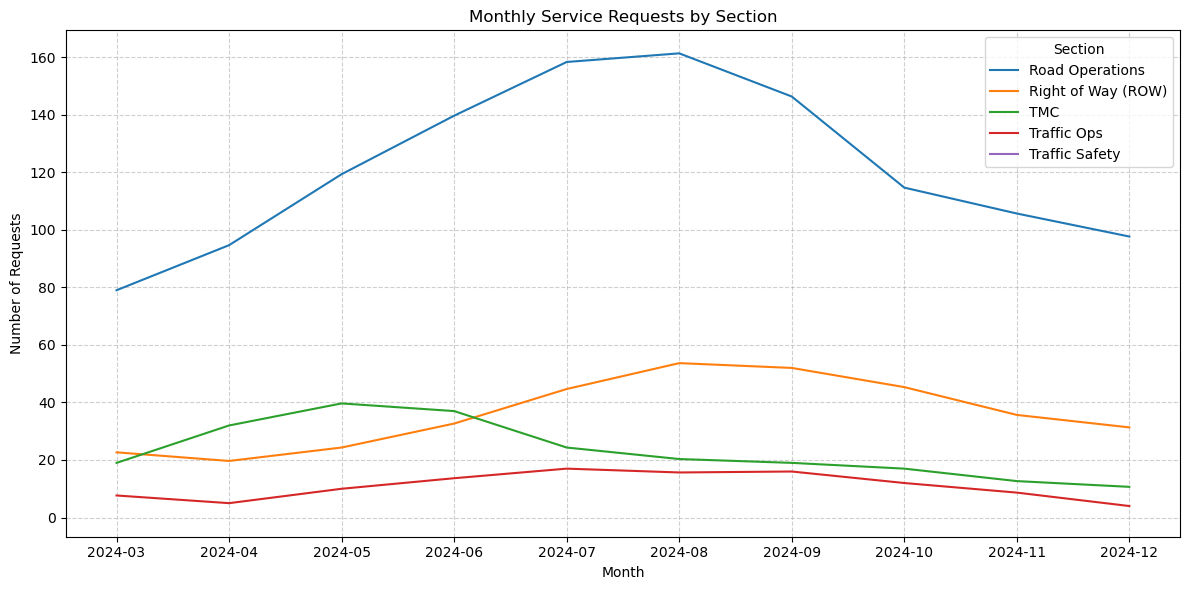

In [32]:
plot_monthly_trend_by_section(
    df,
    sections=[
        "Road Operations",
        "Right of Way (ROW)",
        "TMC",
        "Traffic Ops",
        "Traffic Safety",
    ],
)

In [33]:
def plot_monthly_trend_by_section(
    df,
    sections=None,
    smooth=True,
    normalize=False,
):
    """
    Plot monthly service request trends for selected sections.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'Creation Date' and 'Section' columns.
    sections : list[str] or None, optional
        List of section names to plot. If None, plot the top 5 sections
        by total volume. Default is None.
    smooth : bool, optional
        If True, apply a 3-month rolling average. Default is True.
    normalize : bool, optional
        If True, scale each section's monthly counts to percentages of that
        section's total requests across the plotted months. This helps compare
        seasonal patterns across sections. Default is False.
    """
    df = df.copy()

    df["Creation Date"] = pd.to_datetime(
        df["Creation Date"],
        errors="coerce",
    )
    df["Month"] = df["Creation Date"].dt.to_period("M")

    if sections is None:
        sections = (
            df["Section"]
            .value_counts()
            .head(5)
            .index
            .tolist()
        )

    mask = df["Section"].isin(sections)

    monthly_counts = (
        df.loc[mask]
        .groupby(["Section", "Month"])
        .size()
        .reset_index(name="Count")
    )

    plt.figure(figsize=(12, 6))

    for section in sections:
        section_data = (
            monthly_counts.loc[monthly_counts["Section"] == section]
            .sort_values("Month")
        )

        counts = section_data.set_index("Month")["Count"]

        if normalize:
            total = counts.sum()
            if total > 0:
                counts = counts / total * 100

        if smooth:
            counts = counts.rolling(window=3).mean()

        plt.plot(
            counts.index.astype(str),
            counts.values,
            marker="o",
            label=section,
        )

    if normalize:
        ylabel = "Share of Annual Requests (%)"
        title_suffix = " (Normalized by Section)"
    else:
        ylabel = "Number of Requests"
        title_suffix = ""

    plt.title(
        "Monthly Service Requests by Section" + title_suffix
    )
    plt.xlabel("Month")
    plt.ylabel(ylabel)
    plt.legend(title="Section")
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

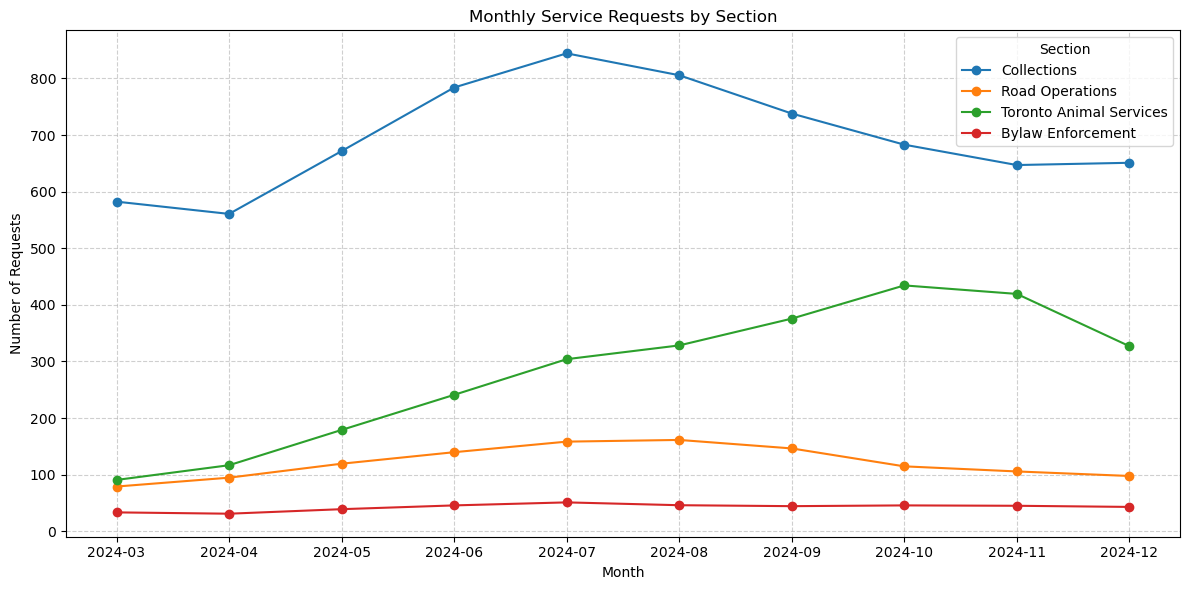

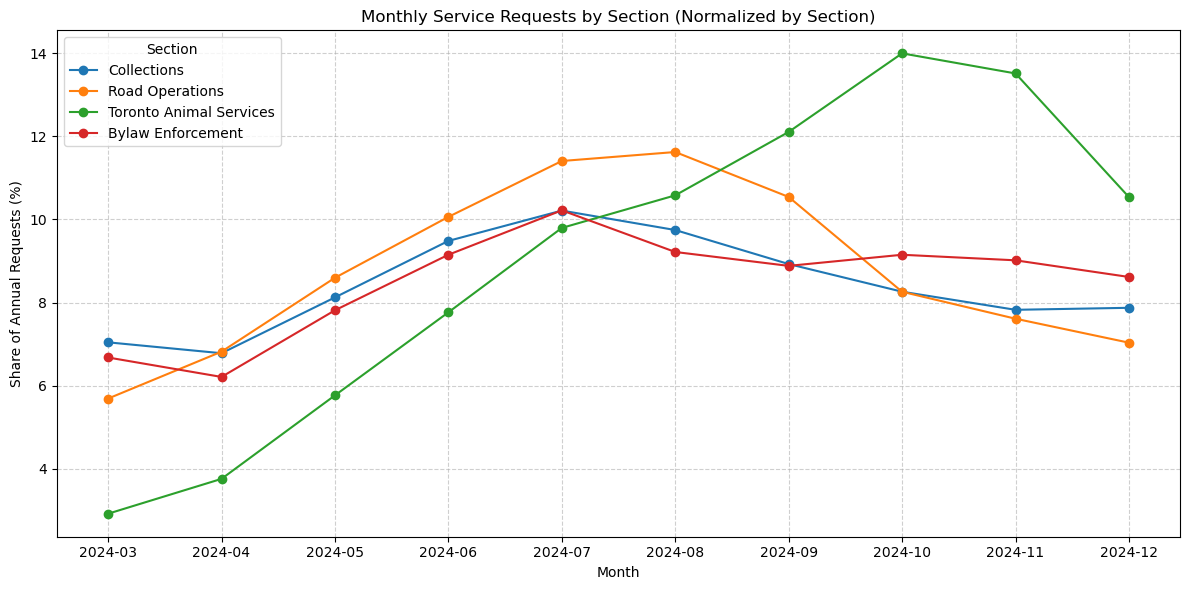

In [34]:
sections_to_plot = [
    "Collections",
    "Road Operations",
    "Toronto Animal Services",
    "Bylaw Enforcement",
]

# Plot monthly trends using absolute counts (smoothed)
plot_monthly_trend_by_section(
    df,
    sections=sections_to_plot,
    smooth=True,
    normalize=False,
)

# Plot monthly trends normalized by each section's annual total (smoothed)
plot_monthly_trend_by_section(
    df,
    sections=sections_to_plot,
    smooth=True,
    normalize=True,
)

Additionlly part: seperate the sections

In [39]:
category_map = {
    # Traffic-related sections
    "Road Operations": "Traffic & Road",
    "Traffic Ops": "Traffic & Road",
    "TMC": "Traffic & Road",
    "Right of Way (ROW)": "Traffic & Road",
    "Traffic Safety": "Traffic & Road",

    # Municipal operations
    "District Ops": "Municipal Ops",
    "Operations": "Municipal Ops",
    "Business Operations Management": "Municipal Ops",
    "Litter Operations": "Municipal Ops",

    # Waste and environmental services
    "Waste Enforcement": "Waste & Environmental",
    "Collections": "Waste & Environmental",

    # Animal services and parks
    "Toronto Animal Services": "Animal & Parks",
    "Parks Enforcement": "Animal & Parks",

    # Enforcement and investigation
    "Bylaw Enforcement": "Enforcement & Investigation",
    "Investigation Services": "Enforcement & Investigation",
    "Business Licensing Enforcement": "Enforcement & Investigation",
}


# Create a higher-level category column
df_all["Category"] = (
    df_all["Section"]
    .map(category_map)
    .fillna("Other")
)

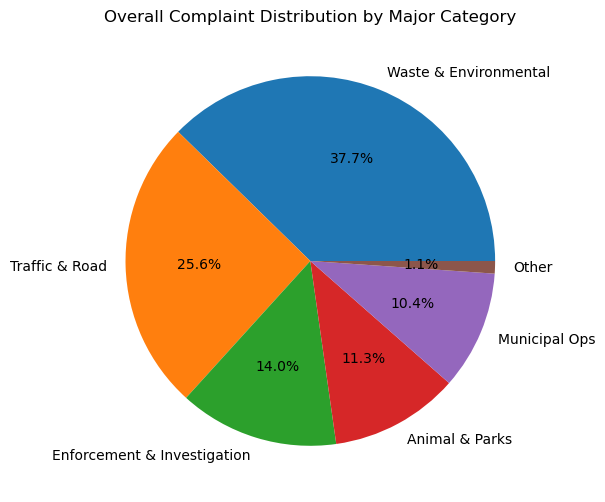

In [40]:
category_counts = df_all["Category"].value_counts()
category_counts.plot(kind="pie", autopct="%.1f%%", figsize=(6,6))
plt.title("Overall Complaint Distribution by Major Category")
plt.ylabel("")
plt.show()

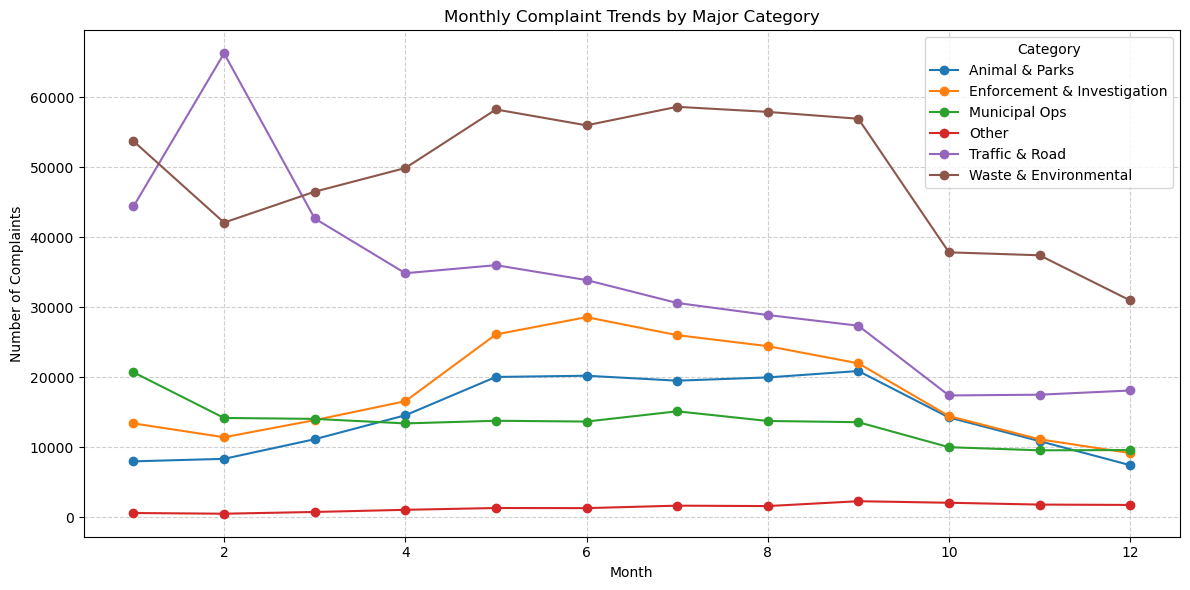

In [41]:
# Ensure Creation Date is in datetime format and extract month number
df_all["Creation Date"] = pd.to_datetime(
    df_all["Creation Date"],
    errors="coerce",
)
df_all["Month"] = df_all["Creation Date"].dt.month


# Aggregate counts by Month and Category
monthly_category_dist = (
    df_all
    .groupby(["Month", "Category"])
    .size()
    .reset_index(name="Count")
    .pivot(
        index="Month",
        columns="Category",
        values="Count",
    )
    .fillna(0)
)


# Plot monthly trends by major category
ax = monthly_category_dist.plot(
    kind="line",
    marker="o",
    figsize=(12, 6),
)

ax.set_title("Monthly Complaint Trends by Major Category")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Complaints")
ax.legend(title="Category")
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


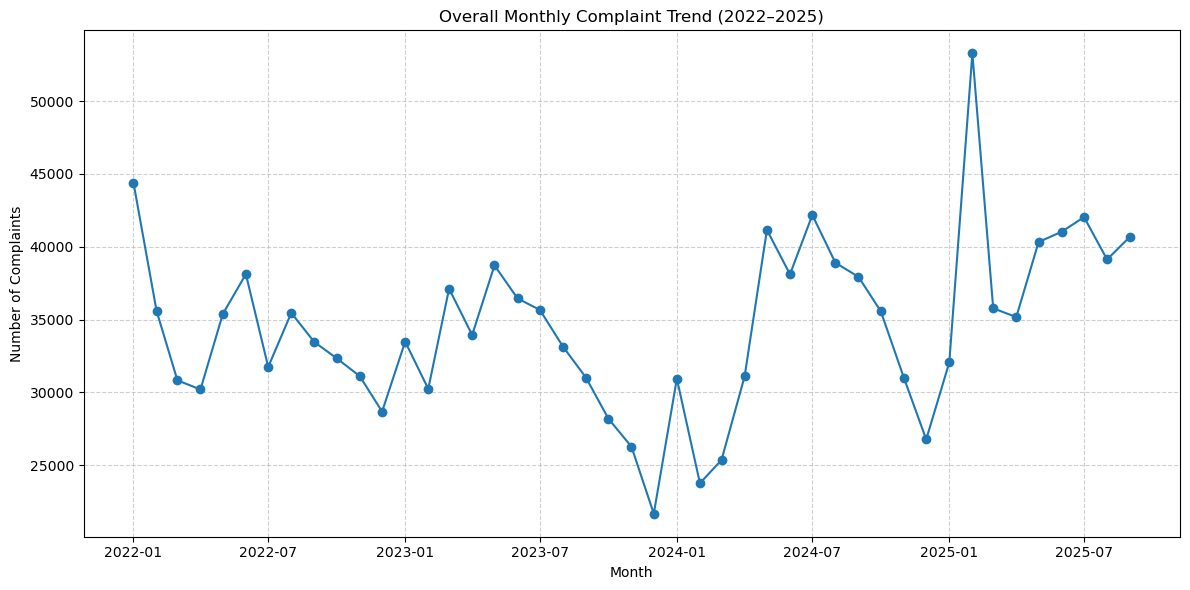

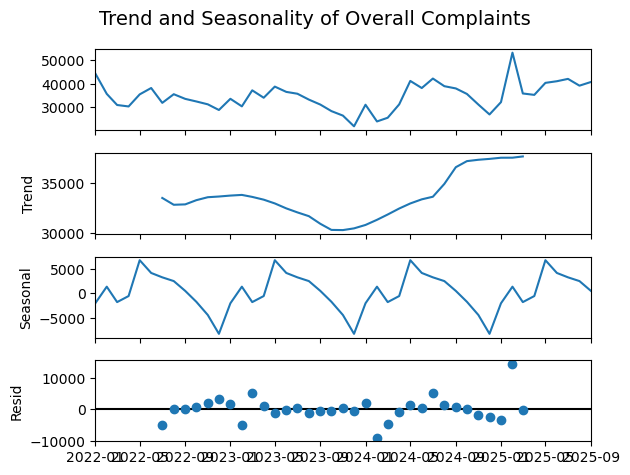

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Ensure Creation Date is in datetime format and create a monthly Period index
df_all["Creation Date"] = pd.to_datetime(
    df_all["Creation Date"],
    errors="coerce",
)
df_all["Month"] = df_all["Creation Date"].dt.to_period("M")


# Compute total monthly complaint counts
monthly_total = df_all.groupby("Month").size()
monthly_total.index = monthly_total.index.to_timestamp()


# Plot overall monthly trend
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_total.index,
    monthly_total.values,
    marker="o",
)
plt.title("Overall Monthly Complaint Trend (2022–2025)")
plt.xlabel("Month")
plt.ylabel("Number of Complaints")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


# Decompose trend and seasonality using an additive model
result = seasonal_decompose(
    monthly_total,
    model="additive",
    period=12,
)

result.plot()
plt.suptitle(
    "Trend and Seasonality of Overall Complaints",
    fontsize=14,
)
plt.tight_layout()
plt.show()


time series analysis for five categories

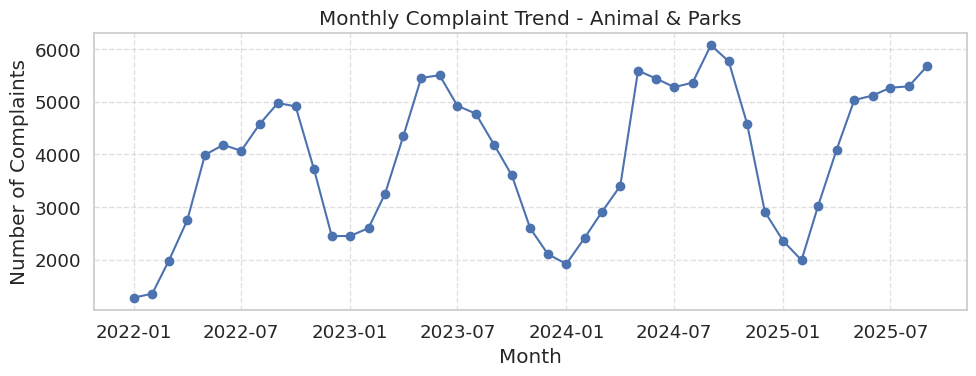

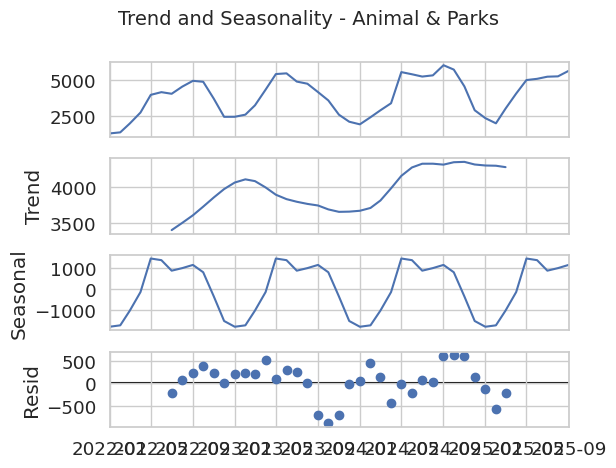

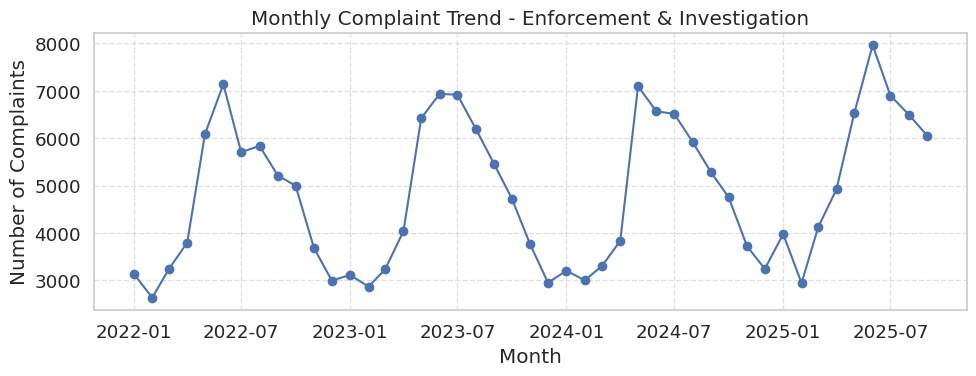

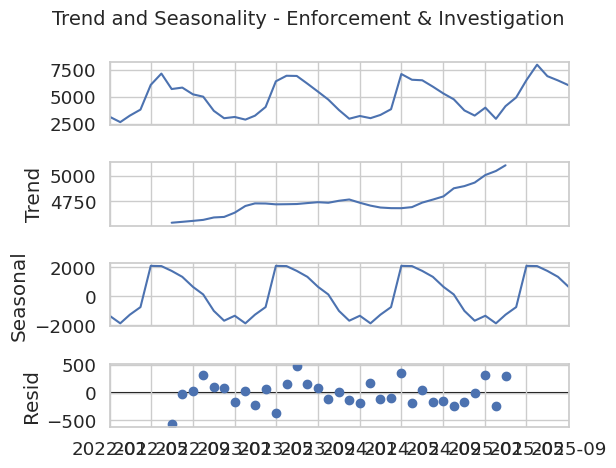

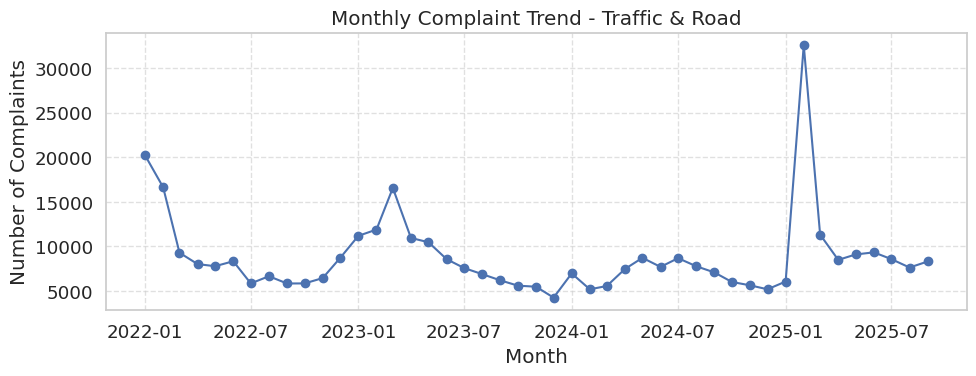

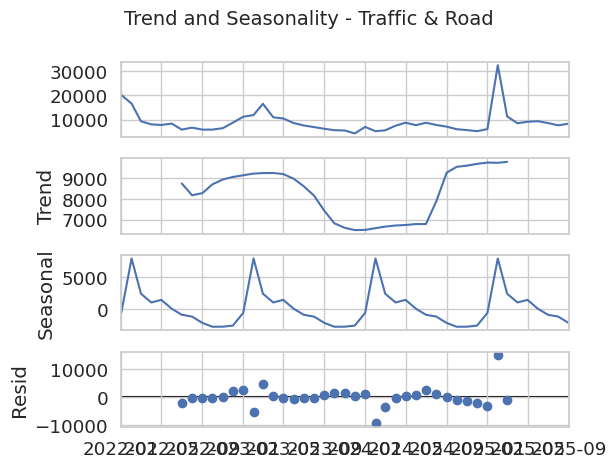

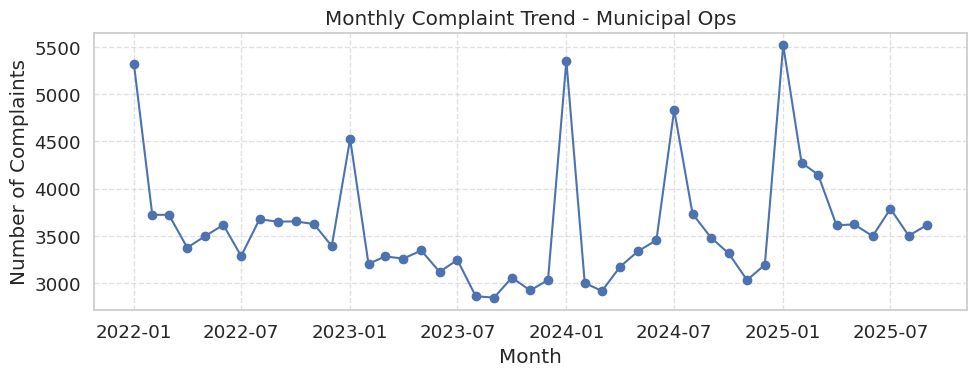

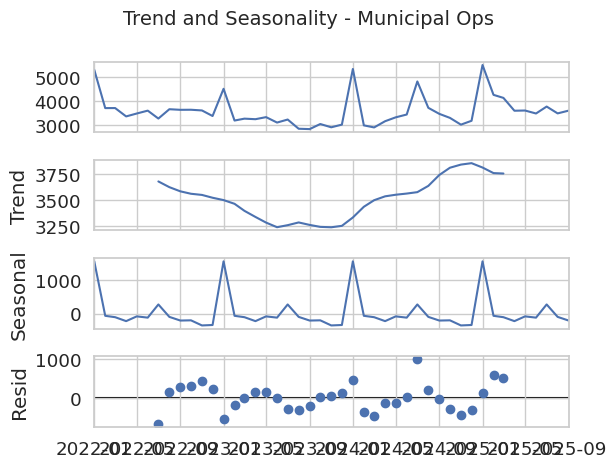

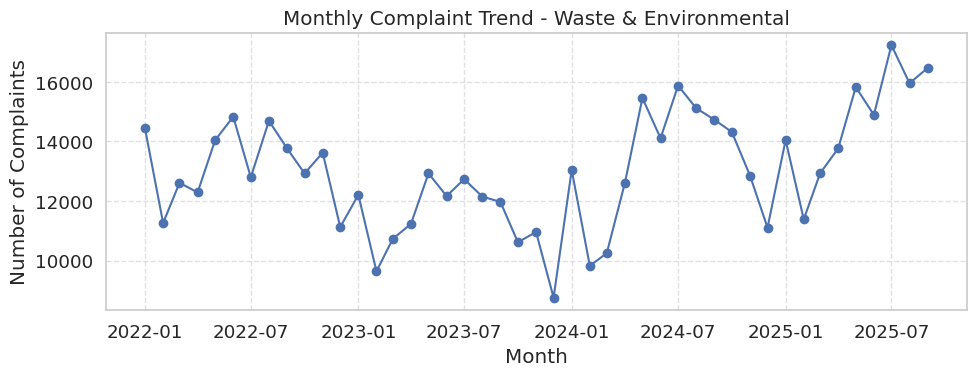

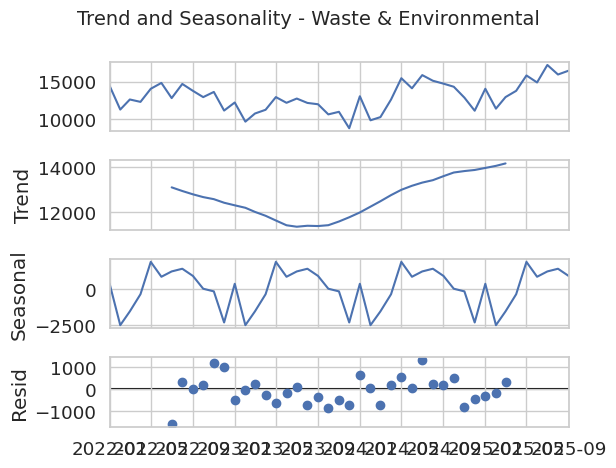

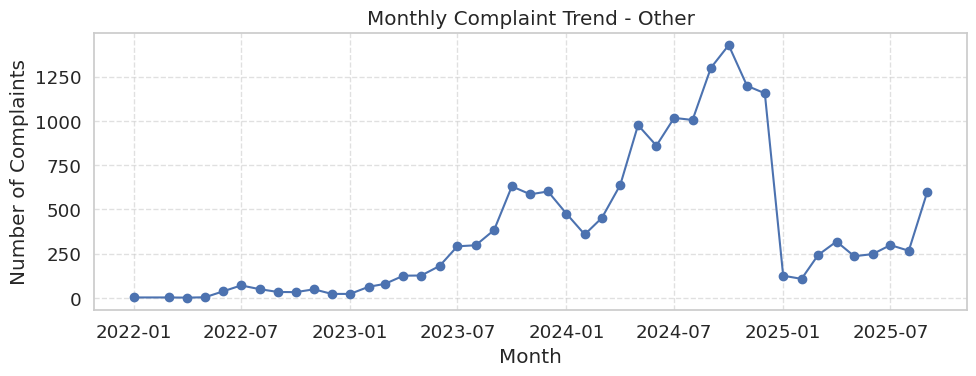

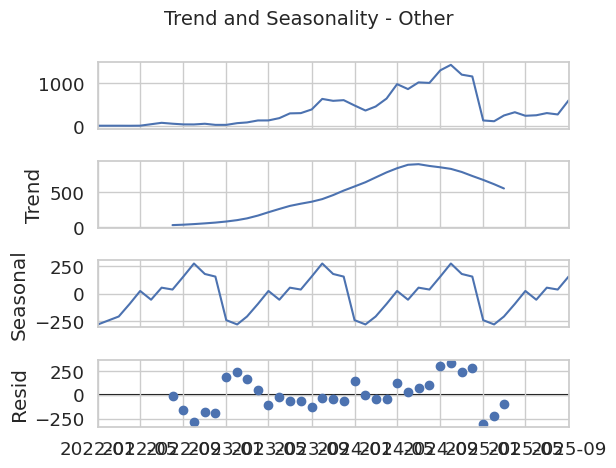

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

categories = df_all["Category"].unique()

for cat in categories:
    subset = df_all[df_all["Category"] == cat]
    monthly_counts = (
        subset.groupby(subset["Creation Date"].dt.to_period("M"))
        .size()
    )
    monthly_counts.index = monthly_counts.index.to_timestamp()

    plt.figure(figsize=(10, 4))
    plt.plot(monthly_counts.index, monthly_counts.values, marker="o")
    plt.title(f"Monthly Complaint Trend - {cat}")
    plt.xlabel("Month")
    plt.ylabel("Number of Complaints")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    if len(monthly_counts) >= 24:
        result = seasonal_decompose(monthly_counts, model='additive', period=12)
        result.plot()
        
        plt.suptitle(f"Trend and Seasonality - {cat}", fontsize=14)
        plt.tight_layout()
        plt.show()

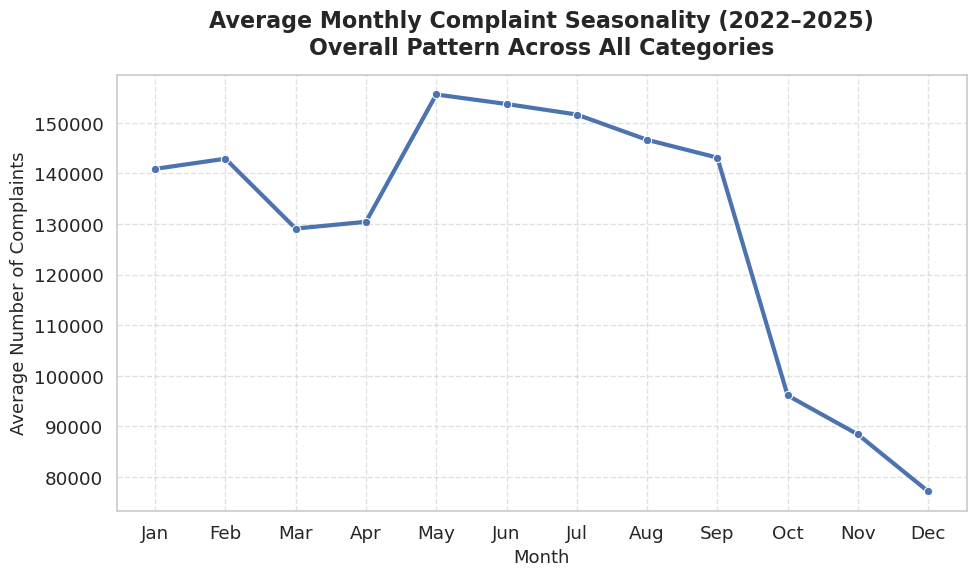

In [46]:
import seaborn as sns
# Set plotting style
sns.set(
    style="whitegrid",
    font_scale=1.2,
)

# Ensure Creation Date is in datetime format
df_all["Creation Date"] = pd.to_datetime(
    df_all["Creation Date"],
    errors="coerce",
)

# Extract month number
df_all["Month"] = df_all["Creation Date"].dt.month


# Compute average monthly complaints across years
monthly_mean = (
    df_all
    .groupby("Month")
    .size()
    .reset_index(name="Average_Complaints")
)


# Plot average monthly seasonality
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=monthly_mean,
    x="Month",
    y="Average_Complaints",
    marker="o",
    linewidth=3,
)

plt.title(
    "Average Monthly Complaint Seasonality (2022–2025)\n"
    "Overall Pattern Across All Categories",
    fontsize=16,
    weight="bold",
    pad=15,
)
plt.xlabel("Month", fontsize=13)
plt.ylabel("Average Number of Complaints", fontsize=13)

plt.xticks(
    range(1, 13),
    [
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec",
    ],
)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


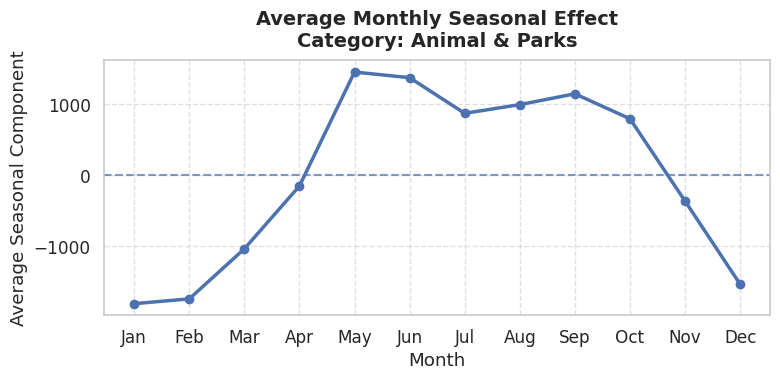

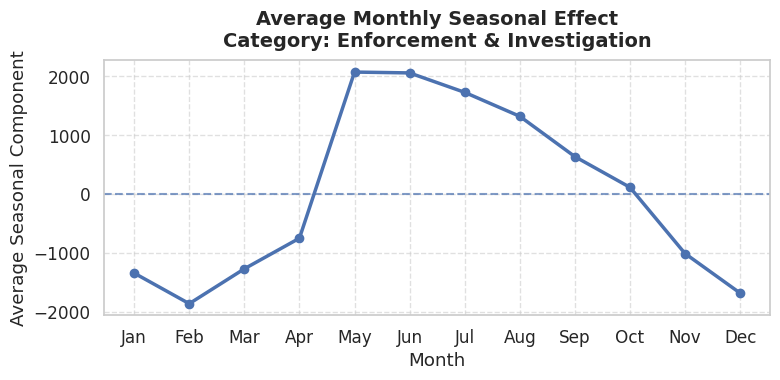

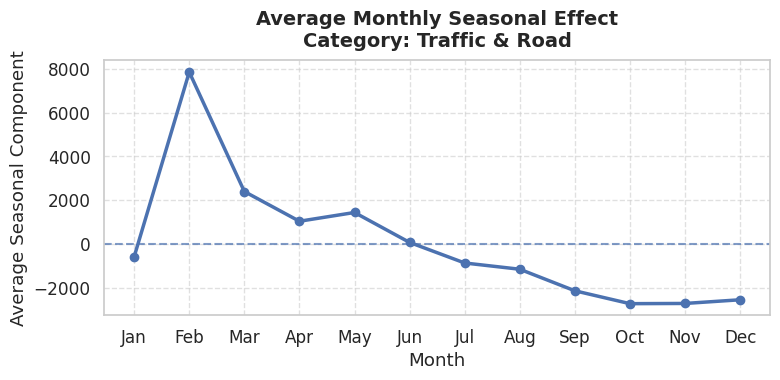

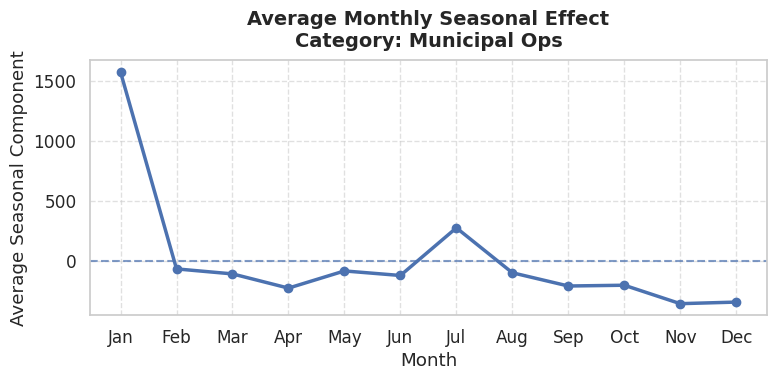

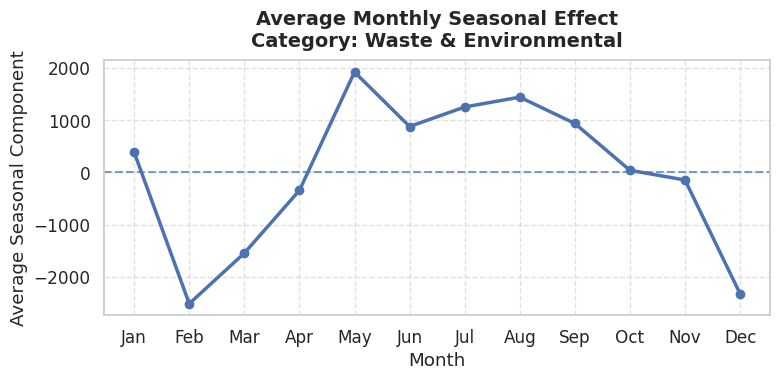

In [48]:
sns.set(
    style="whitegrid",
    font_scale=1.1,
)

# Ensure Creation Date is in datetime format
df_all["Creation Date"] = pd.to_datetime(
    df_all["Creation Date"],
    errors="coerce",
)

# Select categories to analyze (excluding "Other")
all_categories = (
    df_all["Category"]
    .dropna()
    .unique()
    .tolist()
)
categories = [
    category
    for category in all_categories
    if category != "Other"
]

for category in categories:
    subset = df_all.loc[df_all["Category"] == category]

    # Aggregate to monthly counts
    monthly_counts = (
        subset
        .groupby(subset["Creation Date"].dt.to_period("M"))
        .size()
    )
    monthly_counts.index = monthly_counts.index.to_timestamp()
    monthly_counts = monthly_counts.asfreq("MS", fill_value=0)

    # Require at least 24 months for decomposition
    if len(monthly_counts) < 24:
        print(
            f"Category '{category}' has fewer than 24 months of data; "
            "skipping seasonal decomposition."
        )
        continue

    # Decompose the time series and extract the seasonal component
    result = seasonal_decompose(
        monthly_counts,
        model="additive",
        period=12,
    )
    seasonal = result.seasonal

    # Average seasonal component by month-of-year (1-12)
    seasonal_df = pd.DataFrame(
        {
            "Date": seasonal.index,
            "Seasonal": seasonal.values,
        }
    )
    seasonal_df["Month"] = seasonal_df["Date"].dt.month

    avg_seasonality = (
        seasonal_df
        .groupby("Month")["Seasonal"]
        .mean()
        .reset_index()
    )

    # Plot average monthly seasonal effect for the current category
    plt.figure(figsize=(8, 4))
    plt.plot(
        avg_seasonality["Month"],
        avg_seasonality["Seasonal"],
        marker="o",
        linewidth=2.5,
    )

    plt.title(
        "Average Monthly Seasonal Effect\n"
        f"Category: {category}",
        fontsize=14,
        weight="bold",
        pad=10,
    )
    plt.xlabel("Month")
    plt.ylabel("Average Seasonal Component")

    plt.xticks(
        range(1, 13),
        [
            "Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec",
        ],
    )

    plt.axhline(0, linestyle="--", alpha=0.7)
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


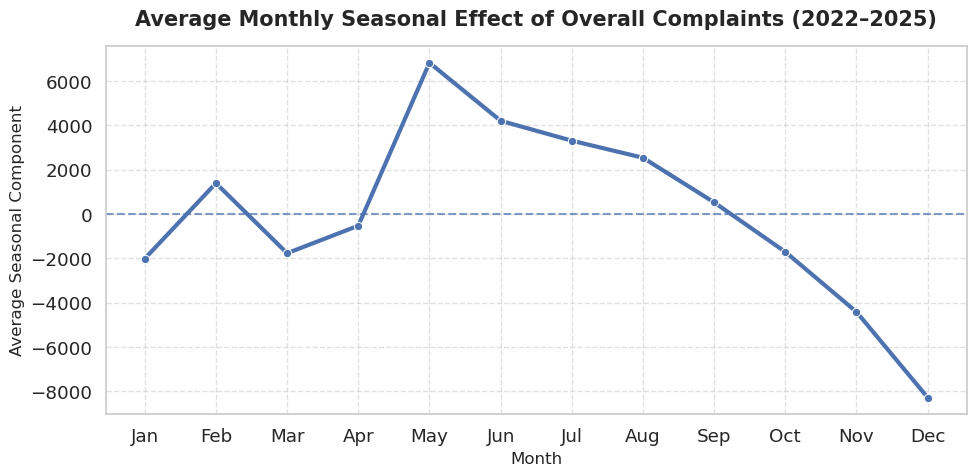

In [49]:
sns.set(
    style="whitegrid",
    font_scale=1.2,
)

# Ensure Creation Date is in datetime format
df_all["Creation Date"] = pd.to_datetime(
    df_all["Creation Date"],
    errors="coerce",
)

# Aggregate total complaints by month
monthly_total = (
    df_all
    .groupby(df_all["Creation Date"].dt.to_period("M"))
    .size()
)

monthly_total.index = monthly_total.index.to_timestamp()
monthly_total = monthly_total.asfreq("MS", fill_value=0)

# Decompose the monthly time series and extract the seasonal component
result = seasonal_decompose(
    monthly_total,
    model="additive",
    period=12,
)
seasonal = result.seasonal

# Average seasonal component by month-of-year (1-12)
seasonal_df = pd.DataFrame(
    {
        "Date": seasonal.index,
        "Seasonal": seasonal.values,
    }
)
seasonal_df["Month"] = seasonal_df["Date"].dt.month

avg_seasonality = (
    seasonal_df
    .groupby("Month")["Seasonal"]
    .mean()
    .reset_index()
)

# Plot average monthly seasonal effect
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=avg_seasonality,
    x="Month",
    y="Seasonal",
    marker="o",
    linewidth=3,
)

plt.title(
    "Average Monthly Seasonal Effect of Overall Complaints (2022–2025)",
    fontsize=15,
    weight="bold",
    pad=15,
)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Seasonal Component", fontsize=12)

plt.xticks(
    range(1, 13),
    [
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec",
    ],
)

plt.axhline(0, linestyle="--", alpha=0.7)
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


extra analysis for graffti.

In [54]:
# Convert text to lowercase to avoid case-sensitivity issues
mask = (
    df_all["Service Request Type"]
    .str.lower()
    .str.contains("graffiti", na=False)
)

# Filter rows matching the condition
filtered_df = df_all.loc[mask]

filtered_df


Creation Date       Status First 3 Chars of Postal Code  \
85      2022-01-01 10:15:46    Completed                          M1E   
106     2022-01-01 11:09:36    Completed                 Intersection   
415     2022-01-02 09:15:52    Cancelled                          M6N   
553     2022-01-02 14:11:34    Completed                 Intersection   
653     2022-01-02 18:05:12    Completed                 Intersection   
...                     ...          ...                          ...   
1555309 2025-09-30 17:35:33  In Progress                          M6H   
1555337 2025-09-30 17:48:13  In Progress                          M4L   
1555416 2025-09-30 18:30:57          New                          M4K   
1555546 2025-09-30 20:23:11  In Progress                 Intersection   
1555619 2025-09-30 22:02:06  In Progress                          M1H   

        Intersection Street 1 Intersection Street 2  \
85                        NaN                   NaN   
106                  Yonge St            Anndale Dr   
415                       NaN                   NaN   
553                  Yonge St            Cummer Ave   
653            Eglinton Ave E            Warden Ave   
...                       ...                   ...   
1555309                   NaN                   NaN   
1555337                   NaN                   NaN   
1555416                   NaN                   NaN   
1555546           Belfield Rd       Martin Grove Rd   
1555619                   NaN                   NaN   

                                Ward  \
85       Scarborough-Rouge Park (25)   
106                  Willowdale (18)   
415                   Davenport (09)   
553                  Willowdale (18)   
653          Scarborough Centre (21)   
...                              ...   
1555309               Davenport (09)   
1555337        Toronto-Danforth (14)   
1555416        Toronto-Danforth (14)   
1555546         Etobicoke North (01)   
1555619   Scarborough-Guildwood (24)   

                                      Service Request Type  \
85                               Road - Graffiti Complaint   
106                      Traffic Sign - Graffiti Complaint   
415                                               Graffiti   
553                                               Graffiti   
653                      Traffic Sign - Graffiti Complaint   
...                                                    ...   
1555309                       Graffiti on Private Property   
1555337                       Graffiti on Private Property   
1555416  Bicycle Stand (Post and Ring) Repair or Graffi...   
1555546   Traffic or Street Name Sign - Graffiti Complaint   
1555619   Traffic or Street Name Sign - Graffiti Complaint   

                                Division                 Section  Month  Year  \
85               Transportation Services         Road Operations      1  2022   
106              Transportation Services                     TMC      1  2022   
415      Municipal Licensing & Standards  Investigation Services      1  2022   
553      Municipal Licensing & Standards  Investigation Services      1  2022   
653              Transportation Services                     TMC      1  2022   
...                                  ...                     ...    ...   ...   
1555309  Municipal Licensing & Standards  Investigation Services      9  2025   
1555337  Municipal Licensing & Standards  Investigation Services      9  2025   
1555416          Transportation Services         Road Operations      9  2025   
1555546          Transportation Services                     TMC      9  2025   
1555619          Transportation Services                     TMC      9  2025   

                            Category  
85                    Traffic & Road  
106                   Traffic & Road  
415      Enforcement & Investigation  
553      Enforcement & Investigation  
653                   Traffic & Road  
...                              ...  
1555

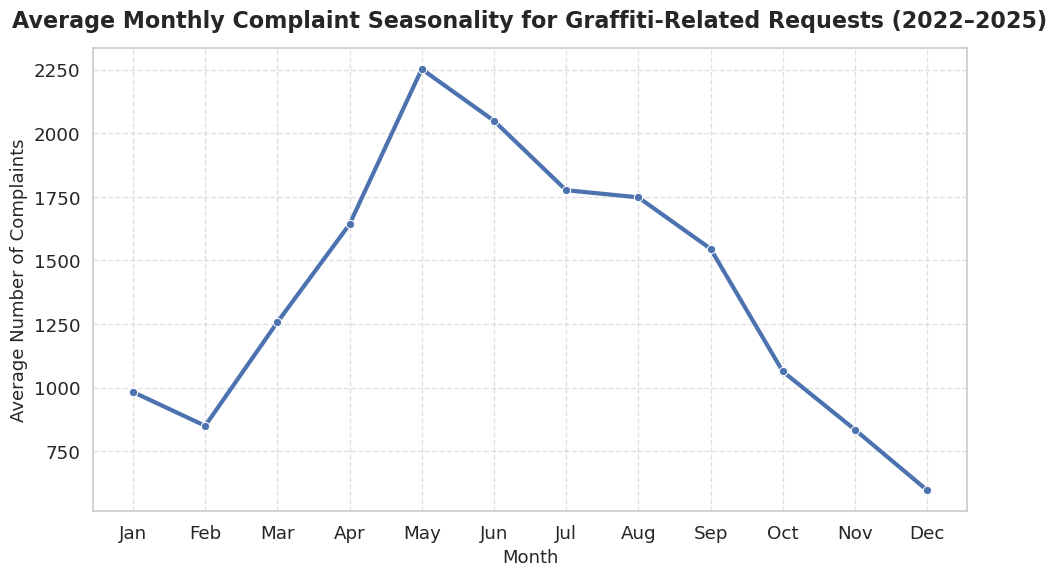

In [55]:
# Set plotting style
sns.set(
    style="whitegrid",
    font_scale=1.2,
)

# Use the filtered graffiti-related data
df_bike_graffiti = filtered_df.copy()

# Ensure Creation Date is in datetime format and extract month number
df_bike_graffiti["Creation Date"] = pd.to_datetime(
    df_bike_graffiti["Creation Date"],
    errors="coerce",
)
df_bike_graffiti["Month"] = df_bike_graffiti["Creation Date"].dt.month


# Compute average monthly complaints across years
monthly_mean = (
    df_bike_graffiti
    .groupby("Month")
    .size()
    .reset_index(name="Average_Complaints")
)


# Plot average monthly seasonality
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=monthly_mean,
    x="Month",
    y="Average_Complaints",
    marker="o",
    linewidth=3,
)

plt.title(
    "Average Monthly Complaint Seasonality for Graffiti-Related Requests (2022–2025)",
    fontsize=16,
    weight="bold",
    pad=15,
)
plt.xlabel("Month", fontsize=13)
plt.ylabel("Average Number of Complaints", fontsize=13)

plt.xticks(
    range(1, 13),
    [
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec",
    ],
)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_430/676380264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Creation Date"] = pd.to_datetime(
/tmp/ipykernel_430/676380264.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Month"] = filtered_df["Creation Date"].dt.to_period("M")


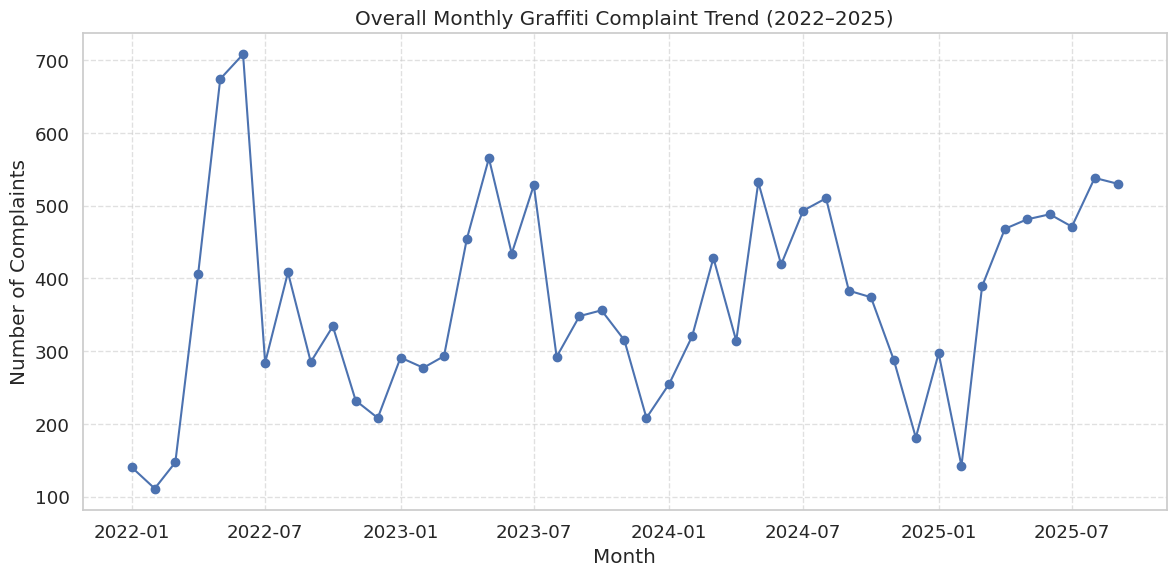

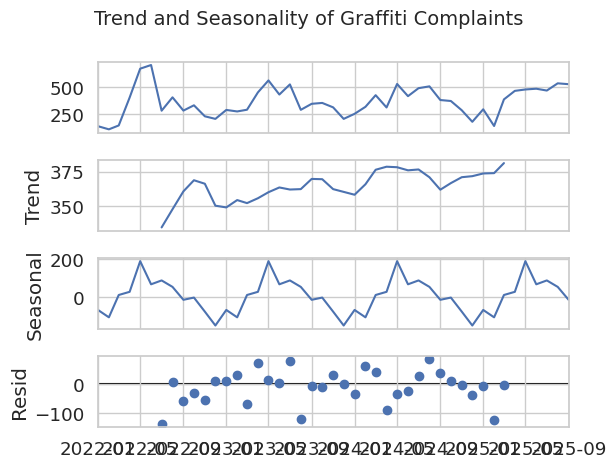

In [56]:
# Ensure Creation Date is in datetime format and create a monthly Period index
filtered_df["Creation Date"] = pd.to_datetime(
    filtered_df["Creation Date"],
    errors="coerce",
)
filtered_df["Month"] = filtered_df["Creation Date"].dt.to_period("M")


# Compute total monthly graffiti complaint counts
monthly_total = filtered_df.groupby("Month").size()
monthly_total.index = monthly_total.index.to_timestamp()


# Plot overall monthly trend
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_total.index,
    monthly_total.values,
    marker="o",
)
plt.title("Overall Monthly Graffiti Complaint Trend (2022–2025)")
plt.xlabel("Month")
plt.ylabel("Number of Complaints")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


# Decompose trend and seasonality using an additive model
result = seasonal_decompose(
    monthly_total,
    model="additive",
    period=12,
)

result.plot()
plt.suptitle(
    "Trend and Seasonality of Graffiti Complaints",
    fontsize=14,
)
plt.tight_layout()
plt.show()
